In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [2]:
import geoplot
import geoplot.crs as gcrs
import folium
import contextily as cx

In [3]:
import pyproj
import matplotlib
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
from shapely.geometry import LineString, Point

In [4]:
# Load cleaned Amsterdam data
df = pd.read_csv('C:/Users/Jiatong/Documents/Air Pollution Project/amsterdamtrips.csv',
                 sep = ";",
                 encoding = "ISO-8859-1")

In [5]:
# Relevant socio-demographic factors
categories = ['OPID', 'HHPers', 'HHSam', 'WoPC', 'Sted', 'GemGr', 'BuurtAdam', 
              'Geslacht', 'Leeftijd', 'Herkomst', 'BetWerk', 'OnbBez', 'MaatsPart', 'Opleiding']

# Relevant journey factors
# VertUur and VertMin for timestamp of journey
# VertPC and AankPC for origin and destination of journey
journey = ['OPID', 'VertPC', 'AankPC', 'VertUur', 'VertMin', 'Reisduur', 'Hvm']

# Subset into categories
factors = df[categories]
trip = df[journey]

# Subset journeys into 3 primary modes of transport
by_car = trip[trip['Hvm'] == 1]
by_foot = trip[trip['Hvm'] == 9]
by_bike = trip[trip['Hvm'] == 8]

In [6]:
# Mapfile location
mapfile_loc = "C:/Users/Jiatong/Documents/Air Pollution Project/Data/Mapfiles/"

# Read files for postcode4 polygons
pc4gs = gpd.read_file(mapfile_loc + 'pc4.json')

In [7]:
# Convert to EPSG 28992
pc4gs = pc4gs.to_crs(epsg = 28992)
res_no2 = gpd.GeoDataFrame(pc4gs, crs="EPSG:28992")

In [9]:
pc4gs['centroid'] = pc4gs.geometry.centroid

In [11]:
pc4gs.to_csv('ams-centroid.csv')

In [4]:
# NO2 hourly data in Amsterdam
no2_loc = "C:/Users/Jiatong/Documents/Air Pollution Project/Data/no2hourly_Ams/"

no2_9 = gpd.read_file(no2_loc + "ams_all_roads_hour9_rf_pred.geojson")
no2_10 = gpd.read_file(no2_loc + "ams_all_roads_hour10_rf_pred.geojson")
no2_11 = gpd.read_file(no2_loc + "ams_all_roads_hour11_rf_pred.geojson")
no2_12 = gpd.read_file(no2_loc + "ams_all_roads_hour12_rf_pred.geojson")
no2_13 = gpd.read_file(no2_loc + "ams_all_roads_hour13_rf_pred.geojson")
no2_14 = gpd.read_file(no2_loc + "ams_all_roads_hour14_rf_pred.geojson")
no2_15 = gpd.read_file(no2_loc + "ams_all_roads_hour15_rf_pred.geojson")
no2_16 = gpd.read_file(no2_loc + "ams_all_roads_hour16_rf_pred.geojson")
no2_17 = gpd.read_file(no2_loc + "ams_all_roads_hour17_rf_pred.geojson")
no2_18 = gpd.read_file(no2_loc + "ams_all_roads_hour18_rf_pred.geojson")
no2_19 = gpd.read_file(no2_loc + "ams_all_roads_hour19_rf_pred.geojson")
no2_20 = gpd.read_file(no2_loc + "ams_all_roads_hour20_rf_pred.geojson")

<AxesSubplot:>

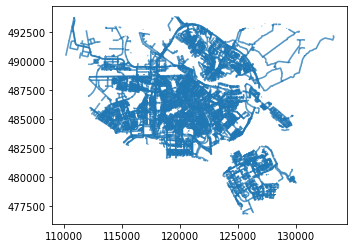

In [5]:
no2_9.plot()

In [17]:
# Collection of all no2 files
no2_col = [no2_9, no2_10, no2_11, no2_12, no2_13, no2_14, no2_15, no2_16, no2_17, no2_18, no2_19, no2_20]

In [18]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

# get a graph
G = ox.graph_from_place('Amsterdam, NL', network_type='bike')

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [19]:
# Project graph
graph_proj = ox.project_graph(G, to_crs='epsg:28992')

# Plot graph
#fig, ax = ox.plot_graph(graph_proj)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [20]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame(geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

for index, row in trip.iterrows():
    origin = row['VertPC']
    target = row['AankPC']

    origin_cent = pc4gs.loc[pc4gs['Postcode4'] == origin].geometry.centroid
    target_cent = pc4gs.loc[pc4gs['Postcode4'] == target].geometry.centroid

    orig_node = ox.distance.nearest_nodes(graph_proj, origin_cent.x, origin_cent.y)
    target_node = ox.distance.nearest_nodes(graph_proj, target_cent.x, target_cent.y)
    
    try:
        route = nx.shortest_path(G=graph_proj, source = orig_node[0], target = target_node[0], weight='length')
        route_nodes = nodes_proj.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))

        # Add a list of osmids associated with the route
        route_geom.loc[index] = [route_line]

    except:
        pass

In [21]:
trips = trip.join(route_geom, how='outer')

In [22]:
route_geom['length_m'] = route_geom.length

In [23]:
trip_gdf = gpd.GeoDataFrame(
    trips, crs = 'EPSG:28992', geometry='geometry')

In [24]:
# Loop through postcode regions and find average NO2 values
times = range(9,21)
hour = 0

for item in no2_col:
    for postcodes in range(len(trip_gdf)):
        if trip_gdf.geometry.values[postcodes] != None:
            no2_value = item[item.intersects(trip_gdf.geometry.values[postcodes])]

            NO2 = np.average(no2_value.iloc[:,3])

            trip_gdf.loc[postcodes, str(times[hour]) + 'NO2_values'] = NO2

        else:
            pass
    
    hour = hour + 1

In [30]:
trip_gdf.to_csv('by_foot_.csv')

In [25]:
#Walkers
W = ox.graph_from_place('Amsterdam, NL', network_type='walk')

# Project graph
graph_proj_w = ox.project_graph(W, to_crs='epsg:28992')

# Get Edges and Nodes
nodes_proj_w, edges_proj_w = ox.graph_to_gdfs(graph_proj_w, nodes=True, edges=True)

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


In [26]:
# Create a GeoDataFrame
route_geom_w = gpd.GeoDataFrame(geometry='geometry', crs=edges_proj_w.crs, columns=['geometry'])

for index, row in trip.iterrows():
    origin = row['VertPC']
    target = row['AankPC']

    origin_cent = pc4gs.loc[pc4gs['Postcode4'] == origin].geometry.centroid
    target_cent = pc4gs.loc[pc4gs['Postcode4'] == target].geometry.centroid

    orig_node = ox.distance.nearest_nodes(graph_proj_w, origin_cent.x, origin_cent.y)
    target_node = ox.distance.nearest_nodes(graph_proj_w, target_cent.x, target_cent.y)
    
    try:
        route = nx.shortest_path(G=graph_proj_w, source = orig_node[0], target = target_node[0], weight='length')
        route_nodes = nodes_proj_w.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))

        # Add a list of osmids associated with the route
        route_geom_w.loc[index] = [route_line]

    except:
        pass
    
route_geom_w['length_m'] = route_geom_w.length

In [27]:
trip_foot = trip.join(route_geom_w, how='outer')

by_foot_gdf = gpd.GeoDataFrame(
    trip_foot, crs = 'EPSG:28992', geometry='geometry')

In [28]:
# Loop through postcode regions and find average NO2 values
times = range(9,21)
hour = 0

for item in no2_col:
    for postcodes in range(len(by_foot_gdf)):
        if by_foot_gdf.geometry.values[postcodes] != None:
            no2_value = item[item.intersects(by_foot_gdf.geometry.values[postcodes])]

            NO2 = np.average(no2_value.iloc[:,3])

            by_foot_gdf.loc[postcodes, str(times[hour]) + 'NO2_values'] = NO2

        else:
            pass
    
    hour = hour + 1

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\mi

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\mi

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Jiatong\mi

In [29]:
by_foot_gdf.to_csv('by_foot_gdf.csv')